In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import arrow
import seaborn as sns

sns.set_style('whitegrid')

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
cs = pd.read_csv('L사_고객정보.csv')
gd = pd.read_csv('L사_상품정보.csv')
tr = pd.read_csv('L사_거래정보.csv')
log = pd.read_csv('L사_로그정보.csv')

C:\Users\gimje\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Data Cleansing

### 1-1. cs (고객정보)

In [3]:
cs.head()

,clnt_id,clnt_gender,clnt_age
0,1,unknown,unknown
1,2,F,30
2,3,unknown,unknown
3,4,unknown,unknown
4,5,unknown,unknown


In [4]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72399 entries, 0 to 72398
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clnt_id      72399 non-null  int64 
 1   clnt_gender  72399 non-null  object
 2   clnt_age     72399 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


#### 성별, 연령이 하나만 unknown인 사람은 존재하지 않고, 둘 다 있거나 둘 다 없는 사람만 존재한다.

In [5]:
cs.query('clnt_gender == "unknown" or clnt_age == "unknown"').shape[0] == cs.query('clnt_gender == "unknown"').shape[0]

True

#### 성별과 연령 값이 unknown인 사람이 약 83%에 해당. - merge한 md 데이터에서는 unknown 존재하지 않음.

In [6]:
print(cs.query('clnt_gender == "unknown"').shape[0] / cs.shape[0])
# print(md.query('clnt_gender == "unknown"').shape[0] / cs.shape[0])

0.8308678296661556


### 1-2. gd (상품정보)

In [7]:
gd.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


In [8]:
gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pd_c      1667 non-null   int64 
 1   clac_nm1  1667 non-null   object
 2   clac_nm2  1667 non-null   object
 3   clac_nm3  1665 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB


#### tr과 gd 데이터의 pd_c 열의 데이터 유형과 자리수를 맞춰준다.

In [9]:
gd.pd_c = gd.pd_c.astype(str).str.zfill(4)

### 1-3. tr (거래정보)

In [10]:
tr.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,21922,104999,1,A03,unknown,20190920,12:41,5990,1
1,21279,104907,4,A03,unknown,20190920,10:27,10900,1
2,39423,105124,11,A03,unknown,20190920,17:26,12900,1
3,18362,104010,1,A03,unknown,20190920,09:57,9900,1
4,39423,105124,13,A03,0565,20190920,17:26,2990,1


In [11]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599961 entries, 0 to 599960
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   clnt_id    599961 non-null  int64 
 1   trans_id   599961 non-null  int64 
 2   trans_seq  599961 non-null  int64 
 3   biz_unit   599961 non-null  object
 4   pd_c       599961 non-null  object
 5   de_dt      599961 non-null  int64 
 6   de_tm      599961 non-null  object
 7   buy_am     599961 non-null  int64 
 8   buy_ct     599961 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 41.2+ MB


#### de_dt열의 데이터 유형을 int에서 datetime으로 변경

In [12]:
tr.de_dt = tr.de_dt.astype(str).astype('datetime64')

### 1-4. lg (로그정보)

In [13]:
log.head() # 구매뿐만 아니라 장바구니 담기 비우기 다른 정보들도 포함.

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,7809,1,8,5,A03,20190913,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN
1,7809,1,4,2,A03,20190913,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN
2,7809,1,11,5,A03,20190913,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN
3,7809,1,1,2,A03,20190913,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN
4,7809,1,9,5,A03,20190913,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN


0.검색 / 1.제품 목록 / 2.제품 세부정보 보기 / 3.장바구니 제품 추가 /
 4.장바구니 제품 삭제 / 5.결제 시도 / 6.구매 완료 / 7.구매 환불 / 8.결제 옵션 

In [14]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196362 entries, 0 to 3196361
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   clnt_id          int64  
 1   sess_id          int64  
 2   hit_seq          int64  
 3   action_type      int64  
 4   biz_unit         object 
 5   sess_dt          int64  
 6   hit_tm           object 
 7   hit_pss_tm       int64  
 8   trans_id         float64
 9   sech_kwd         object 
 10  tot_pag_view_ct  float64
 11  tot_sess_hr_v    float64
 12  trfc_src         object 
 13  dvc_ctg_nm       object 
dtypes: float64(3), int64(6), object(5)
memory usage: 341.4+ MB


In [15]:
log.isnull().sum()

clnt_id                  0
sess_id                  0
hit_seq                  0
action_type              0
biz_unit                 0
sess_dt                  0
hit_tm                   0
hit_pss_tm               0
trans_id           3139373
sech_kwd           2544724
tot_pag_view_ct       1428
tot_sess_hr_v        57607
trfc_src                 0
dvc_ctg_nm         1782577
dtype: int64

#### action_type이 6(구매 완료), 7(구매 환불)이 아닌 경우는 trans_id가 결측값

In [16]:
log.query("action_type in [0,1,2,3,4,5,8]").trans_id.unique()

array([nan])

#### action_type이 0(검색)이 아닌 경우는 sech_kwd가 결측값

In [17]:
log.query("action_type in [1,2,3,4,5,6,7,8]").sech_kwd.unique()

array([nan], dtype=object)

#### tot_pag_view_ct와 tot_sess_hr_v는 action_type과 관계없이 결측값 발생

In [18]:
log.query("action_type in [5]").tot_pag_view_ct.isna().value_counts()

False    750459
True         71
Name: tot_pag_view_ct, dtype: int64

In [19]:
log.query("action_type in [0]").tot_sess_hr_v.isna().value_counts()

False    649342
True       2296
Name: tot_sess_hr_v, dtype: int64

#### dvc_ctg_nm는 action_type이 8 (결제 옵션)일때를 제외하고 결측값 발생

In [20]:
log.query("action_type in [8]").dvc_ctg_nm.unique()

array([], dtype=object)

#### sess_dt 열의 데이터 유형을 int에서 datetime으로 변경

In [21]:
log.sess_dt = log.sess_dt.astype(str).astype('datetime64')

# MD

In [22]:
md = pd.merge(tr, cs).merge(gd, on='pd_c')
md.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
1,39423,105124,10,A03,0182,2019-09-20,17:26,21800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
2,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
3,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
4,18362,50872,3,A03,0182,2019-07-15,09:46,31600,4,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups


In [23]:
md.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582309 entries, 0 to 582308
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   clnt_id      582309 non-null  int64         
 1   trans_id     582309 non-null  int64         
 2   trans_seq    582309 non-null  int64         
 3   biz_unit     582309 non-null  object        
 4   pd_c         582309 non-null  object        
 5   de_dt        582309 non-null  datetime64[ns]
 6   de_tm        582309 non-null  object        
 7   buy_am       582309 non-null  int64         
 8   buy_ct       582309 non-null  int64         
 9   clnt_gender  582309 non-null  object        
 10  clnt_age     582309 non-null  object        
 11  clac_nm1     582309 non-null  object        
 12  clac_nm2     582309 non-null  object        
 13  clac_nm3     582283 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(8)
memory usage: 66.6+ MB


### 이상치 정리하기

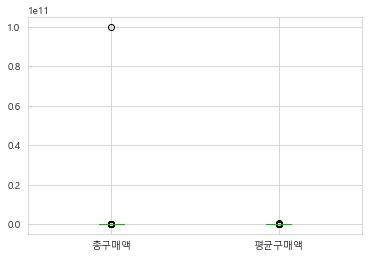

In [24]:
md.groupby('clnt_id').buy_am.agg([('총구매액',np.sum),('평균구매액',np.mean)]).plot.box()

#### 구매액이 과도하게 큰 고객 제거하기

In [25]:
md = md.drop(md.query('buy_am == buy_am.max()').index) 

#### buy_am, buy_ct 열 정리하기

In [26]:
# 둘 다 0인 경우 삭제
md = md.drop(md.query(" buy_am ==0 and buy_ct == 0").index)  

# 금액은 0이 아니지만 수량이 0인 경우
# 구매금액이 평균보다 크면 수량을 2, 작으면 1로 변경
md['buy_ct'] = np.where(md['buy_am'] > md['buy_am'].mean(), 2 , 1 )

# 수량은 0이 아니지만 금액이 0인 경우는 전체의 0.01%이므로 삭제 
md.query("buy_am == 0 and buy_ct != 0 ").shape[0] / md.shape[0]
md = md.drop(md.query(" buy_am ==0 and buy_ct != 0").index)

### MD 데이터 간단히 살펴보기

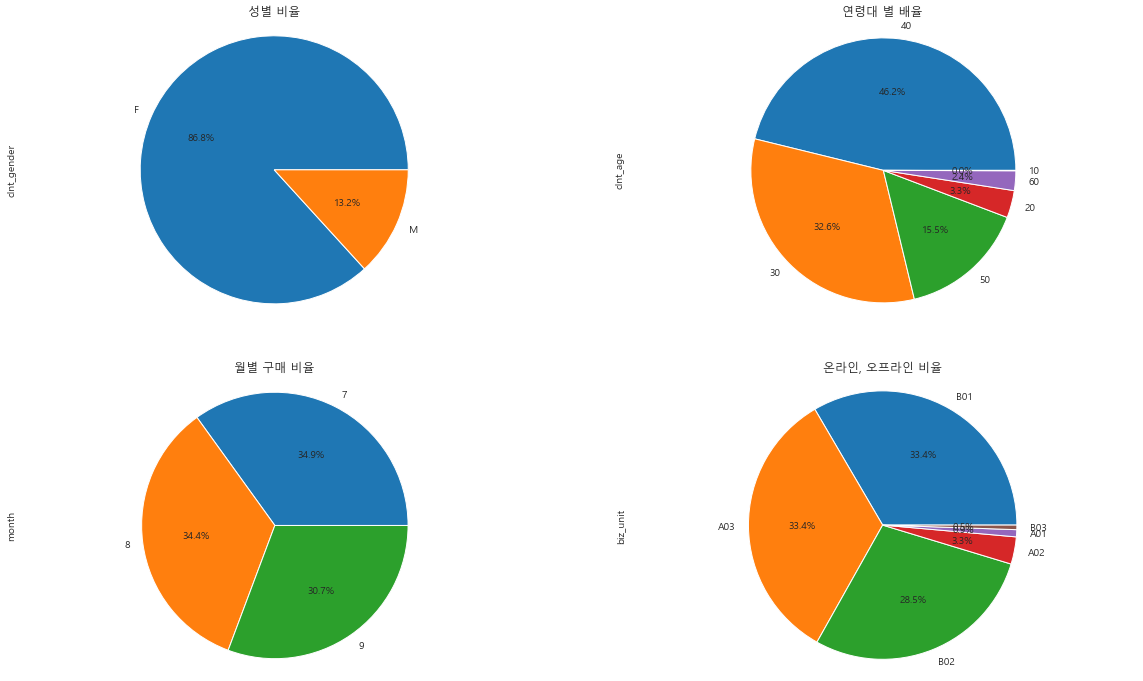

In [27]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
g = md.clnt_gender.value_counts()
g.plot.pie(autopct = "%.1f%%")
plt.title('성별 비율')
plt.axis('equal')


plt.subplot(2,2,2)
a = md.clnt_age.value_counts()
a.plot.pie(autopct = "%.1f%%")
plt.title('연령대 별 배율')
plt.axis('equal')

md['month'] = md['de_dt'].dt.month 


plt.subplot(2,2,3)
m = md.month.value_counts()
m.plot.pie(autopct = "%.1f%%")
plt.title('월별 구매 비율')
plt.axis('equal')

plt.subplot(2,2,4)
a = md.biz_unit.value_counts()
a.plot.pie(autopct = "%.1f%%")
plt.title('온라인, 오프라인 비율')
plt.axis('equal')
plt.show()

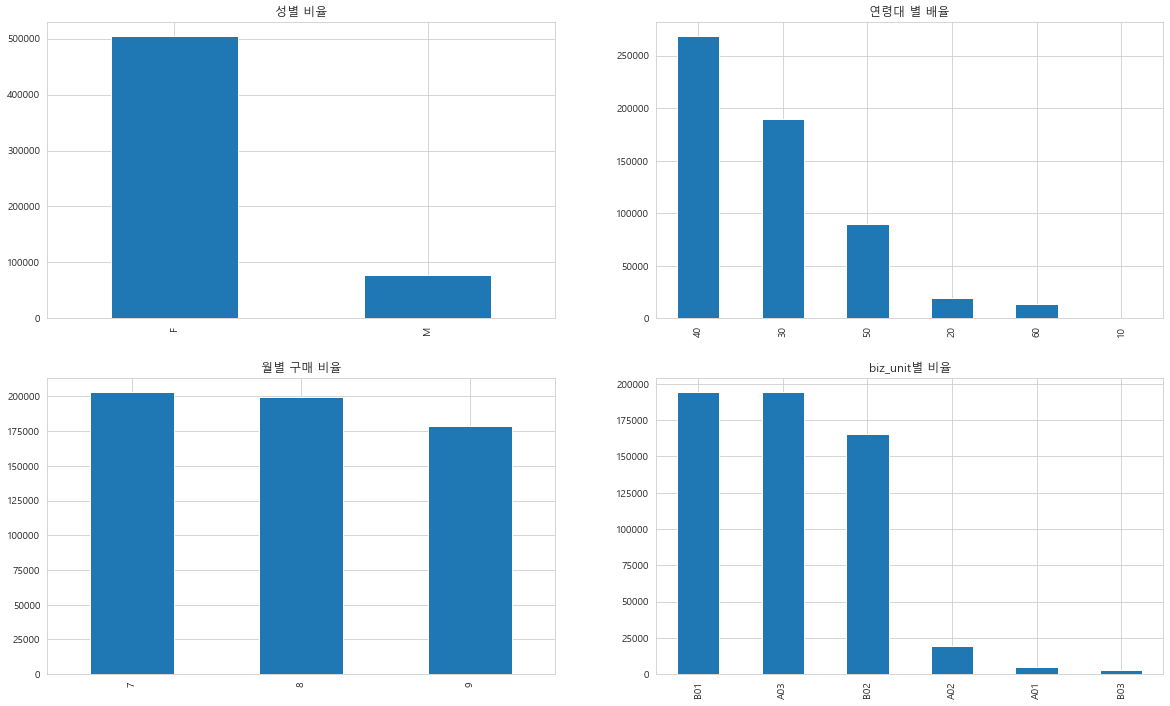

In [28]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
g = md.clnt_gender.value_counts()
g.plot.bar()
plt.title('성별 비율')


plt.subplot(2,2,2)
a = md.clnt_age.value_counts()
a.plot.bar()
plt.title('연령대 별 배율')

md['month'] = md['de_dt'].dt.month 

plt.subplot(2,2,3)
m = md.month.value_counts()
m.plot.bar()
plt.title('월별 구매 비율')

plt.subplot(2,2,4)
a = md.biz_unit.value_counts()
a.plot.bar()
plt.title('biz_unit별 비율')
plt.show()

# 2. RFM 분석

### Recency value

#### md 에서의 recency

In [29]:
now = md.de_dt.max()+pd.DateOffset(days=1) # 최종 구매일 다음날을 기준으로 계산 

md_recency = (md.groupby('clnt_id')['de_dt'].agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'de_dt':'md_recency'}))
md_recency

,clnt_id,md_recency
0,2,32
1,9,17
2,12,38
3,20,1
4,23,3
...,...,...
11261,72373,15
11262,72400,23
11263,72410,12
11264,72423,14


최근 구매 내역은 없지만 로그 기록이 있는 사람을 이탈 고객 ( 휴면 고객 )으로 간주하는 것은 비합리적이라고 판단하여, 
로그 정보까지 합쳐서 계산.

#### 로그정보에서의 recency 

In [30]:
now = log.sess_dt.max()+pd.DateOffset(days=1) # 최종 구매일 다음날을 기준으로 계산 


log_recency = (log.groupby('clnt_id')['sess_dt'].agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'sess_dt':'log_recency'})
          )
log_recency

,clnt_id,log_recency
0,1,9
1,2,30
2,3,78
3,4,36
4,5,43
...,...,...
72394,72425,15
72395,72426,1
72396,72427,57
72397,72428,13


In [31]:
recency = pd.merge(md_recency, log_recency)

# md_recency 와 lg_recency 중에 더 작은 값을 뽑아서 recency 라는 새로운 열에 저장
recency['recency'] = [ recency['md_recency'][i] if recency['md_recency'][i] < recency['log_recency'][i] else recency['log_recency'][i]for i in range(recency.shape[0])]


#del recency['md_recency']
#del recency['log_recency']

recency

,clnt_id,md_recency,log_recency,recency
0,2,32,30,30
1,9,17,6,6
2,12,38,75,38
3,20,1,62,1
4,23,3,6,3
...,...,...,...,...
11261,72373,15,1,1
11262,72400,23,62,23
11263,72410,12,67,12
11264,72423,14,14,14


### Frequency value

In [32]:
frequency =  md.groupby('clnt_id')['trans_id'].agg([('frequency', Series.nunique)]).reset_index()

frequency

,clnt_id,frequency
0,2,6
1,9,7
2,12,1
3,20,7
4,23,9
...,...,...
11261,72373,9
11262,72400,4
11263,72410,16
11264,72423,2


### Monetary value

In [33]:
monetary = md.groupby('clnt_id')['buy_am'].agg([('monetary', np.sum)]).reset_index()
monetary

,clnt_id,monetary
0,2,157100
1,9,339941
2,12,29900
3,20,238580
4,23,202964
...,...,...
11261,72373,1038950
11262,72400,302710
11263,72410,463670
11264,72423,499500


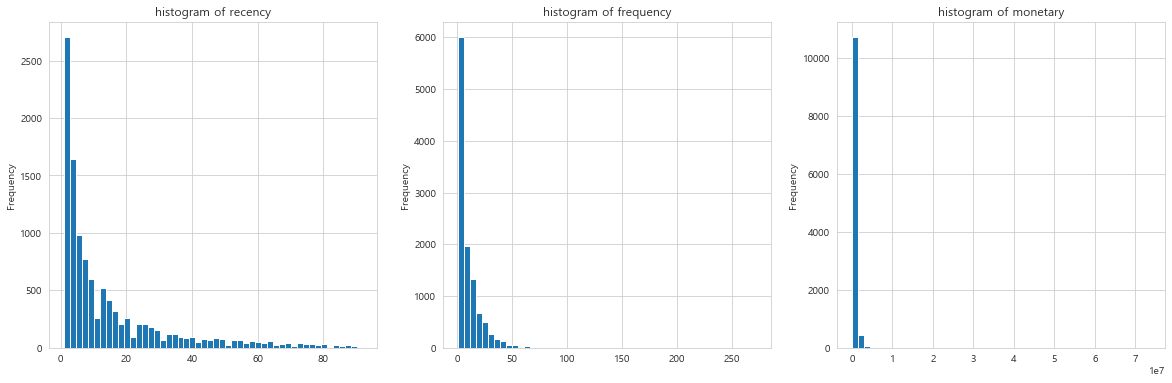

In [34]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
recency.recency.plot.hist(bins=50, title='histogram of recency')
plt.subplot(1,3,2)
frequency.frequency.plot.hist(bins=50, title='histogram of frequency')
plt.subplot(1,3,3)
monetary.monetary.plot.hist(bins=50, title='histogram of monetary')
plt.show()

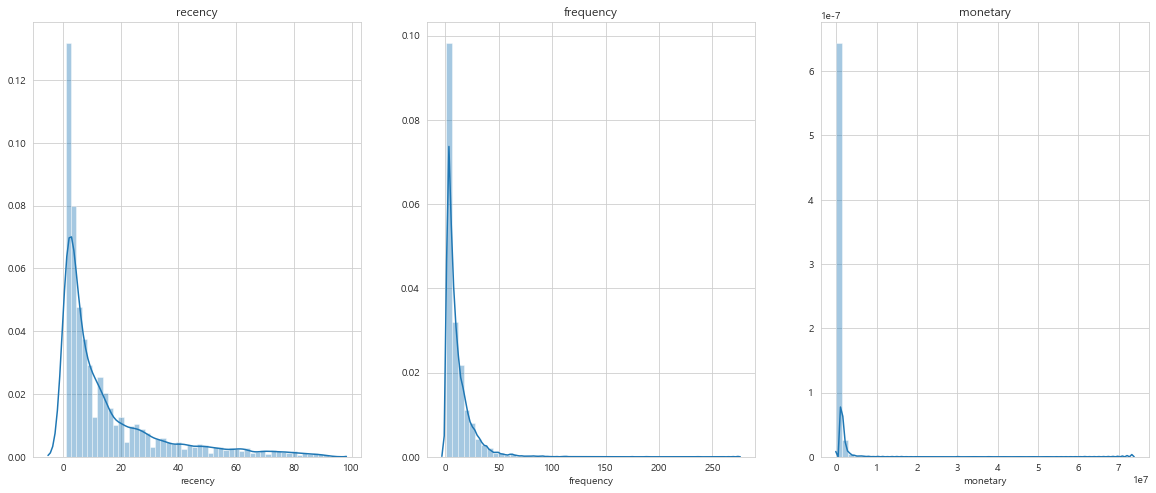

In [35]:
f, ax = plt.subplots(1, 3, figsize=(20,8))

sns.distplot(recency.recency, ax=ax[0])

ax[0].set_title('recency')

sns.distplot(frequency.frequency, ax=ax[1])
ax[1].set_title('frequency')

sns.distplot(monetary.monetary, ax=ax[2])
ax[2].set_title('monetary')
plt.show()

### RFM group

In [36]:
del recency['md_recency'] # recency 열만 남기고 삭제
del recency['log_recency']

# recency, frequency, monetary 데이터 프레임 합치기

rfm = recency.merge(frequency).merge(monetary)
rfm

,clnt_id,recency,frequency,monetary
0,2,30,6,157100
1,9,6,7,339941
2,12,38,1,29900
3,20,1,7,238580
4,23,3,9,202964
...,...,...,...,...
11261,72373,1,9,1038950
11262,72400,23,4,302710
11263,72410,12,16,463670
11264,72423,14,2,499500


In [37]:
# recency, frequency, monetary 값을 각각 5분위로 분류하여 1~5까지 점수 부여
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=range(5,0,-1)).astype(int)
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=range(1,6)).astype(int)
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=range(1,6)).astype(int)

# RFMgroup 만들기
rfm['RFMgroup'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

print(rfm.RFMgroup.nunique())

rfm

119


,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup
0,2,30,6,157100,1,3,2,132
1,9,6,7,339941,3,3,3,333
2,12,38,1,29900,1,1,1,111
3,20,1,7,238580,5,3,3,533
4,23,3,9,202964,4,4,3,443
...,...,...,...,...,...,...,...,...
11261,72373,1,9,1038950,5,4,5,545
11262,72400,23,4,302710,2,2,3,223
11263,72410,12,16,463670,2,4,4,244
11264,72423,14,2,499500,2,1,4,214


#### segement

<img align='left' src='https://miro.medium.com/max/1400/0*BnDRv_eWWPmFpkKv'>

In [38]:
# 위 그림에 따라 고객 세분화 
seg_map = { 
    r'[1-2]1' : 'lost',
    r'12' : 'lost',
    r'22': 'hibernating',
    r'[1-2][3-4]' : 'at risk',
    r'25' : 'at risk',
    r'15' : 'can not loose them',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-5]4': 'loyal customers',
    r'[3-4]5': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'55': 'champions'
}

rfm['RFM_segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['RFM_segment'] = rfm['RFM_segment'].replace(seg_map, regex=True)
rfm.head()

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup,RFM_segment
0,2,30,6,157100,1,3,2,132,at risk
1,9,6,7,339941,3,3,3,333,need attention
2,12,38,1,29900,1,1,1,111,lost
3,20,1,7,238580,5,3,3,533,potential loyalists
4,23,3,9,202964,4,4,3,443,loyal customers


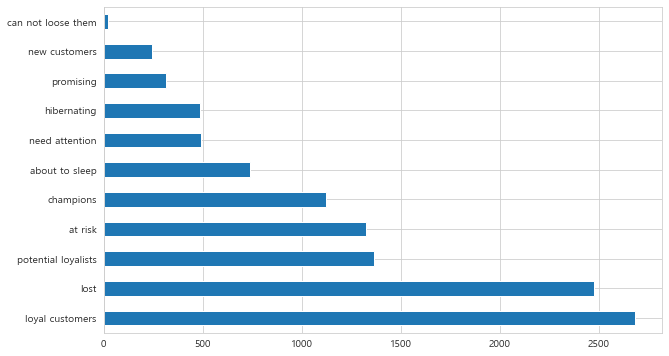

In [39]:
plt.figure(figsize = (10,6))
rfm.RFM_segment.value_counts().plot.barh()

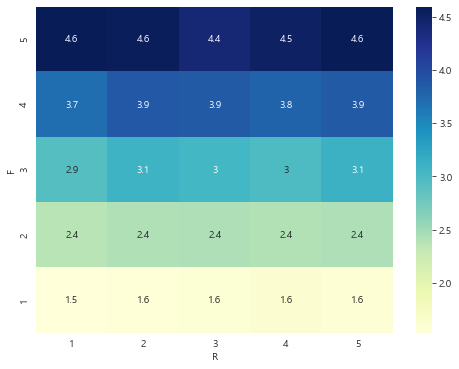

In [40]:
# Recency & Frequency Grid에 Monetary 정보를 추가한 그림
pv = pd.pivot_table(rfm, index='F', columns='R', values='M', aggfunc=np.mean).iloc[::-1,:]
plt.figure(figsize=(8,6))
sns.heatmap(pv, annot=True, cmap="YlGnBu")

#### md와 rfm merge하기

In [41]:
df = pd.merge(md, rfm) ; df

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,...,clac_nm3,month,recency,frequency,monetary,R,F,M,RFMgroup,RFM_segment
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,2,F,...,Chilled Soups,9,6,6,79980,3,3,1,331,need attention
1,21922,104999,4,A03,0178,2019-09-20,12:41,9900,2,F,...,Chilled Noodles,9,6,6,79980,3,3,1,331,need attention
2,21922,102455,3,A03,1584,2019-09-18,21:07,2990,1,F,...,Onions,9,6,6,79980,3,3,1,331,need attention
3,21922,102455,1,A03,0943,2019-09-18,21:07,11160,2,F,...,Domestic Beefs - Rounds,9,6,6,79980,3,3,1,331,need attention
4,21922,102455,5,A03,1566,2019-09-18,21:07,3890,1,F,...,Cucumbers,9,6,6,79980,3,3,1,331,need attention
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581777,15146,68684,1,A01,1273,2019-08-05,10:58,52800,2,M,...,Men's Climbing Bodysuits,8,2,1,52800,5,1,1,511,new customers
581778,53632,75835,1,A01,0258,2019-08-14,10:00,77040,2,M,...,Printer Inks / Toners,8,48,1,77040,1,1,1,111,lost
581779,58443,103525,1,A01,0263,2019-09-18,10:30,568000,2,F,...,Tablet PCs,9,1,1,568000,5,1,4,514,new customers
581780,21232,103476,1,A01,0263,2019-09-18,01:38,362500,2,F,...,Tablet PCs,9,13,1,362500,2,1,4,214,lost


In [42]:
lost = df.query('RFM_segment == "lost"')
hibernating = df.query('RFM_segment == "hibernating"')
at_risk = df.query('RFM_segment == "at risk"')
can_not_lose_them = df.query('RFM_segment == "can not loose them"')
about_to_sleep = df.query('RFM_segment == "about to sleep"')
need_attention = df.query('RFM_segment == "need attention"')
loyal_customers = df.query('RFM_segment == "loyal customers"')
promising = df.query('RFM_segment == "promising"')
new_customers = df.query('RFM_segment == "new customers"')
potential_loyalists = df.query('RFM_segment == "potential loyalists"')
champions = df.query('RFM_segment == "champions"')

## segment_features

In [43]:
# 총구매액, 최대구매액, 최소구매액 
a = df.groupby('RFM_segment').buy_am.agg([
    ('총구매액',np.sum),
    ('최대구매액', max),
    ('최소구매액', min)]).reset_index()

# 거래당 평균구매액
b = (df.groupby('RFM_segment').buy_am.sum() / df.groupby('RFM_segment').buy_ct.sum()).agg(lambda x : x.round(-1)).reset_index()
b.columns = ['RFM_segment','거래당구매액']

# 고가상품구매율, 저가상품구매율
df['gd_price'] = df['buy_am'] / df['buy_ct']
h_price = df.groupby('pd_c')['gd_price'].mean().quantile(0.75)
l_price = df.groupby('pd_c')['gd_price'].mean().quantile(0.25)

c = df.groupby('RFM_segment')['gd_price'].agg([('고가상품구매율', lambda x: (x > h_price).mean().round(2)),
                                            ('저가상품구매율', lambda x: (x < l_price).mean().round(2))]).reset_index()
# 평균구매건수
d = df.groupby('RFM_segment').buy_ct.agg([('평균구매건수',np.mean)]).agg(lambda x: x.round()).reset_index()

# 주구매시간
df['de_hour']= df.de_tm.agg(lambda x : x[:2]) 
e = df.groupby('RFM_segment').de_hour.agg(lambda x : x.value_counts().index[0]).reset_index()
e.columns = ['RFM_segment','주구매시간']

# 내점일수, 평일방문율, 주말방문율
f = df.groupby('RFM_segment')['de_dt'].agg([
    ('내점일수', lambda x : x.nunique()),
    ('평일방문율', lambda x: (x.dt.weekday < 5).mean().round(2)),
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2))]).reset_index()

l = pd.merge(a,b).merge(c)
lf = pd.merge(l,d).merge(e)
RFM_segment_features = pd.merge(lf,f)
RFM_segment_features

,RFM_segment,총구매액,최대구매액,최소구매액,거래당구매액,고가상품구매율,저가상품구매율,평균구매건수,주구매시간,내점일수,평일방문율,주말방문율
0,about to sleep,131012574,2799000,10,13160.0,0.08,0.56,1.0,16,87,0.66,0.34
1,at risk,847617629,11800000,20,12220.0,0.07,0.58,1.0,17,81,0.72,0.28
2,can not loose them,19048398,386000,210,7330.0,0.05,0.59,1.0,19,67,0.77,0.23
3,champions,1286602582,2954340,3,6250.0,0.03,0.65,1.0,17,92,0.73,0.27
4,hibernating,107423191,1345880,10,12110.0,0.09,0.55,1.0,16,81,0.72,0.28
5,lost,327125162,2943000,20,16050.0,0.12,0.52,1.0,12,81,0.74,0.26
6,loyal customers,2107584839,11578450,10,7310.0,0.03,0.63,1.0,17,92,0.73,0.27
7,need attention,174177027,2970000,100,8840.0,0.05,0.60,1.0,11,87,0.72,0.28
8,new customers,24123903,1198000,100,13600.0,0.11,0.56,1.0,14,92,0.72,0.28
9,potential loyalists,412716350,3979000,10,8540.0,0.04,0.60,1.0,11,92,0.70,0.30


Text(0.5, 1.0, 'RFM_segment별 저가상품구매율')

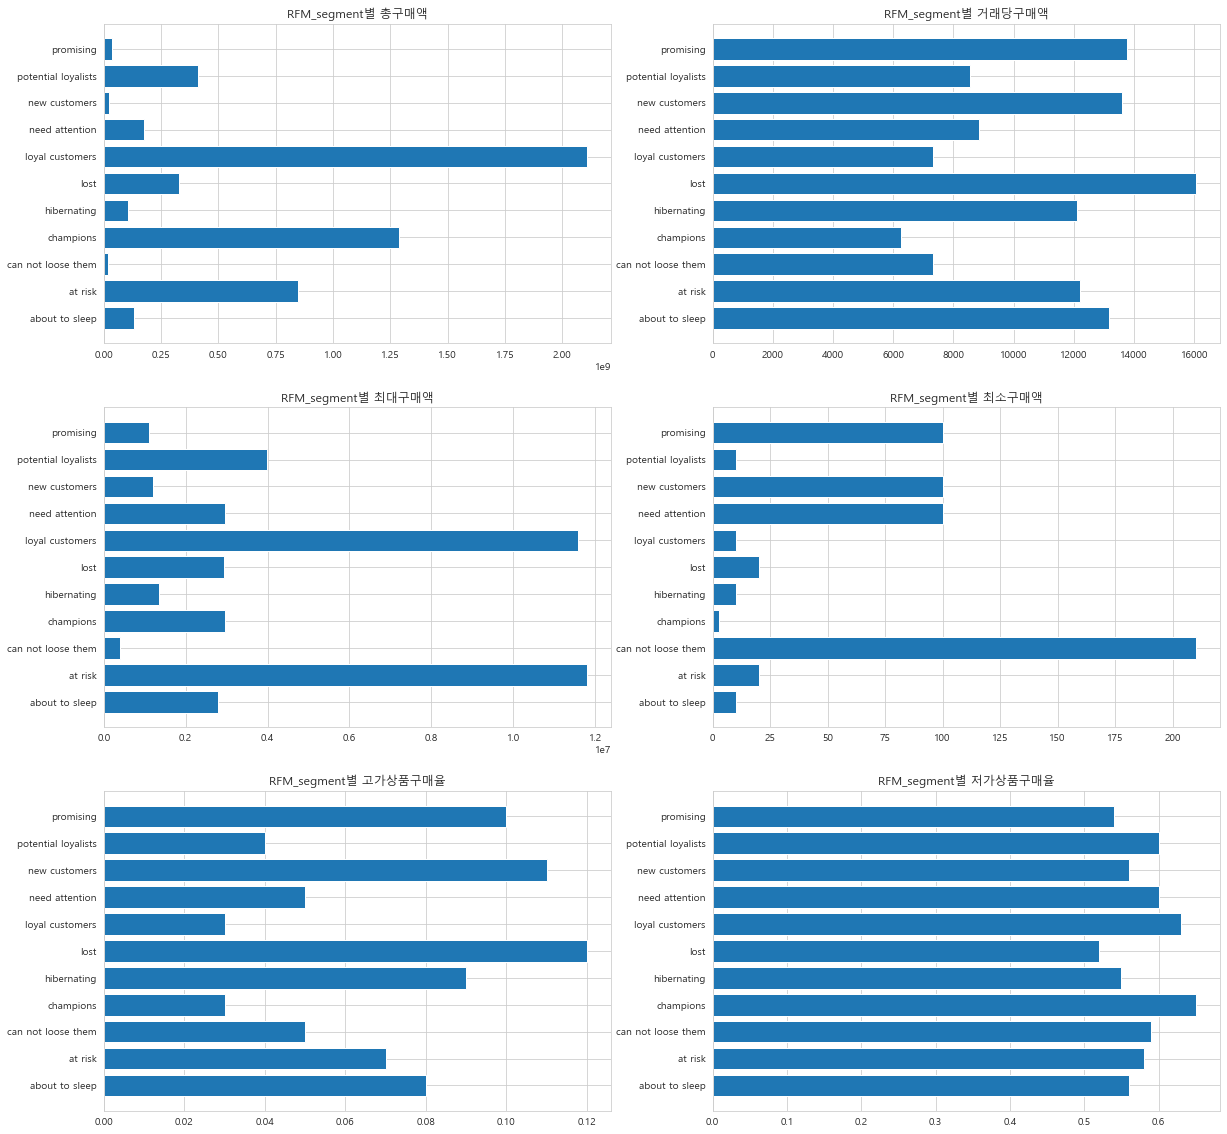

In [44]:
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plt.barh(RFM_segment_features.RFM_segment, RFM_segment_features.총구매액)
plt.title('RFM_segment별 총구매액')

plt.subplot(3,2,2)
plt.barh(RFM_segment_features.RFM_segment, RFM_segment_features.거래당구매액)
plt.title('RFM_segment별 거래당구매액')

plt.subplot(3,2,3)
plt.barh(RFM_segment_features.RFM_segment, RFM_segment_features.최대구매액)
plt.title('RFM_segment별 최대구매액')

plt.subplot(3,2,4)
plt.barh(RFM_segment_features.RFM_segment, RFM_segment_features.최소구매액)
plt.title('RFM_segment별 최소구매액')

plt.subplot(3,2,5)
plt.barh(RFM_segment_features.RFM_segment, RFM_segment_features.고가상품구매율)
plt.title('RFM_segment별 고가상품구매율')

plt.subplot(3,2,6)
plt.barh(RFM_segment_features.RFM_segment, RFM_segment_features.저가상품구매율)
plt.title('RFM_segment별 저가상품구매율')

### segment별 베스트셀러

In [45]:
sb2 = DataFrame({seg: df.query('RFM_segment == @seg').clac_nm2.value_counts().head(5).index for seg in seg_map.values()}) ; sb2

,lost,hibernating,at risk,can not loose them,about to sleep,need attention,loyal customers,promising,new customers,potential loyalists,champions
0,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Instant Noodles,Snacks,Snacks,Snacks
1,Instant Noodles,Frozen Instant Foods,Domestic Fruits,Beer,Instant Noodles,Frozen Instant Foods,Milk,Frozen Instant Foods,Instant Noodles,Frozen Instant Foods,Milk
2,Frozen Instant Foods,Instant Noodles,Instant Noodles,Frozen Instant Foods,Frozen Instant Foods,Instant Noodles,Domestic Fruits,Snacks,Frozen Instant Foods,Instant Noodles,Domestic Fruits
3,Domestic Fruits,Domestic Fruits,Frozen Instant Foods,Leaf Vegetables,Domestic Fruits,Milk,Frozen Instant Foods,Domestic Fruits,Leaf Vegetables,Domestic Fruits,Tofu / Bean Sprouts
4,Milk,Milk,Milk,Milk,Milk,Domestic Fruits,Tofu / Bean Sprouts,Milk,Tofu / Bean Sprouts,Tofu / Bean Sprouts,Yogurt


In [46]:
sb3 = DataFrame({seg: df.query('RFM_segment == @seg').clac_nm3.value_counts().head(5).index for seg in seg_map.values()}) ; sb3

,lost,hibernating,at risk,can not loose them,about to sleep,need attention,loyal customers,promising,new customers,potential loyalists,champions
0,General Snacks,Ramens,General Snacks,General Snacks,Ramens,General Snacks,General Snacks,Ramens,Ramens,General Snacks,General Snacks
1,Ramens,General Snacks,Ramens,Trash Bags,General Snacks,Ramens,Fresh Milk,General Snacks,Tofu,Ramens,Fresh Milk
2,Chicken Eggs,Chicken Eggs,Fresh Milk,Domestic Beer,Chicken Eggs,Chicken Eggs,Chicken Eggs,Fresh Milk,Chicken Eggs,Chicken Eggs,Trash Bags
3,Fresh Milk,Corn Snacks,Chicken Eggs,Fresh Milk,Fresh Milk,Fresh Milk,Tofu,Chicken Eggs,General Snacks,Fresh Milk,Tofu
4,Bibim Ramens,Fresh Milk,Trash Bags,Fixed-price Living Products,Water,Tofu,Ramens,Spoon Type Yogurts,Water,Tofu,Chicken Eggs


# 3. segment2 만들기 

In [47]:
# 총구매액, 최대구매액, 최소구매액 
a = df.groupby('clnt_id').buy_am.agg([
    ('총구매액',np.sum),
    ('최대구매액', max),
    ('최소구매액', min)]).reset_index()

# 거래당 평균구매액
b = (df.groupby('clnt_id').buy_am.sum() / df.groupby('clnt_id').buy_ct.sum()).agg(lambda x : x.round(-1)).reset_index()
b.columns = ['clnt_id','거래당구매액']

# 고가상품구매율, 저가상품구매율
df['gd_price'] = df['buy_am'] / df['buy_ct']
h_price = df.groupby('pd_c')['gd_price'].mean().quantile(0.75)
l_price = df.groupby('pd_c')['gd_price'].mean().quantile(0.25)

c = df.groupby('clnt_id')['gd_price'].agg([('고가상품구매율', lambda x: (x > h_price).mean().round(2)),
                                            ('저가상품구매율', lambda x: (x < l_price).mean().round(2))]).reset_index()

AP_features = pd.merge(a,b).merge(c)
AP_features

,clnt_id,총구매액,최대구매액,최소구매액,거래당구매액,고가상품구매율,저가상품구매율
0,2,157100,46430,1800,10470.0,0.25,0.58
1,9,339941,149500,990,7390.0,0.03,0.51
2,12,29900,29900,29900,14950.0,0.00,0.00
3,20,238580,18900,990,4680.0,0.00,0.58
4,23,202964,27000,490,3760.0,0.00,0.78
...,...,...,...,...,...,...,...
11261,72373,1038950,449000,1290,29680.0,0.25,0.15
11262,72400,302710,148000,30000,37840.0,0.75,0.00
11263,72410,463670,81600,500,7030.0,0.07,0.67
11264,72423,499500,479700,19800,124880.0,0.50,0.00


In [48]:
a = AP_features['고가상품구매율'].quantile(0.75)

In [49]:
# recency, frequency, monetary 값을 각각 5분위로 분류하여 점수 부여
AP_features['M0'] = pd.qcut(AP_features['총구매액'], q=5, labels=range(1,6)).astype(int)
AP_features['M1'] = pd.qcut(AP_features['최대구매액'], q=5, labels=range(1,6)).astype(int)
AP_features['M2'] = pd.qcut(AP_features['최소구매액'], q=5, labels=range(6,1,-1)).astype(int)
AP_features['M3'] = pd.qcut(AP_features['거래당구매액'], q=5, labels=range(1,6)).astype(int)
AP_features['M4'] = np.where(AP_features['고가상품구매율'] > AP_features['고가상품구매율'].quantile(0.75) , 2 , 1)
AP_features['M5'] = np.where(AP_features['저가상품구매율'] < AP_features['저가상품구매율'].quantile(0.25) , 2 , 1)

AP_features['M'] = AP_features['M0'] + AP_features['M1'] + AP_features['M2'] + AP_features['M3'] + AP_features['M4']
AP_features['m'] =  pd.qcut(AP_features['M'], q=5, labels=range(1,6)).astype(int)
AP_features

,clnt_id,총구매액,최대구매액,최소구매액,거래당구매액,고가상품구매율,저가상품구매율,M0,M1,M2,M3,M4,M5,M,m
0,2,157100,46430,1800,10470.0,0.25,0.58,2,3,3,4,2,1,14,3
1,9,339941,149500,990,7390.0,0.03,0.51,3,5,4,3,1,1,16,4
2,12,29900,29900,29900,14950.0,0.00,0.00,1,2,2,4,1,2,10,1
3,20,238580,18900,990,4680.0,0.00,0.58,3,2,4,2,1,1,12,2
4,23,202964,27000,490,3760.0,0.00,0.78,3,2,5,1,1,1,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,72373,1038950,449000,1290,29680.0,0.25,0.15,5,5,3,5,2,2,20,5
11262,72400,302710,148000,30000,37840.0,0.75,0.00,3,5,2,5,2,2,17,4
11263,72410,463670,81600,500,7030.0,0.07,0.67,4,4,5,3,1,1,17,4
11264,72423,499500,479700,19800,124880.0,0.50,0.00,4,5,2,5,2,2,18,4


### segment2 지정하기 

In [50]:
seg_map = { 
    r'5' : 'diamond',
    r'4' : 'platinum',
    r'3': 'gold',
    r'2' : 'silver',
    r'1' : 'bronze' }

AP_features['AP_segment'] = AP_features['m'].map(str)
AP_features['AP_segment'] = AP_features['AP_segment'].replace(seg_map, regex=True)
AP_features.head()

,clnt_id,총구매액,최대구매액,최소구매액,거래당구매액,고가상품구매율,저가상품구매율,M0,M1,M2,M3,M4,M5,M,m,AP_segment
0,2,157100,46430,1800,10470.0,0.25,0.58,2,3,3,4,2,1,14,3,gold
1,9,339941,149500,990,7390.0,0.03,0.51,3,5,4,3,1,1,16,4,platinum
2,12,29900,29900,29900,14950.0,0.00,0.00,1,2,2,4,1,2,10,1,bronze
3,20,238580,18900,990,4680.0,0.00,0.58,3,2,4,2,1,1,12,2,silver
4,23,202964,27000,490,3760.0,0.00,0.78,3,2,5,1,1,1,12,2,silver


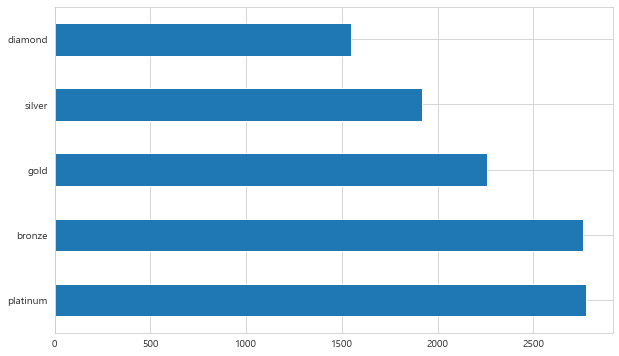

In [51]:
plt.figure(figsize = (10,6))
AP_features.AP_segment.value_counts().plot.barh()

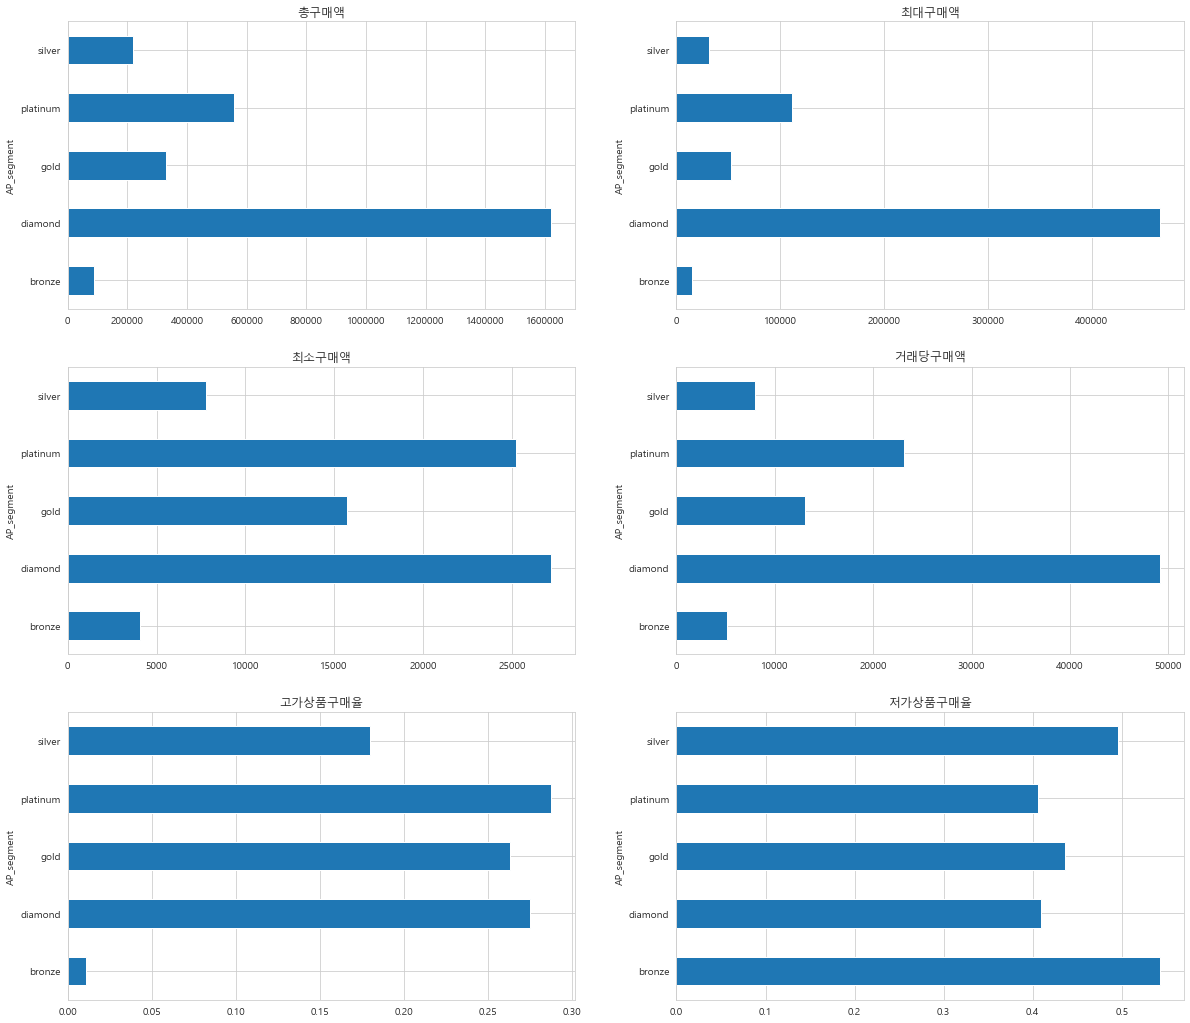

In [52]:
plt.figure(figsize = (20,18))
plt.subplot(3,2,1)
AP_features.groupby('AP_segment').총구매액.mean().plot.barh(title = '총구매액')
plt.subplot(3,2,2)
AP_features.groupby('AP_segment').최대구매액.mean().plot.barh(title = '최대구매액')
plt.subplot(3,2,3)
AP_features.groupby('AP_segment').최소구매액.mean().plot.barh(title='최소구매액')
plt.subplot(3,2,4)
AP_features.groupby('AP_segment').거래당구매액.mean().plot.barh(title = '거래당구매액')
plt.subplot(3,2,5)
AP_features.groupby('AP_segment').고가상품구매율.mean().plot.barh(title = '고가상품구매율')
plt.subplot(3,2,6)
AP_features.groupby('AP_segment').저가상품구매율.mean().plot.barh(title = '저가상품구매율')

### 전체 merge

In [53]:
AP = AP_features[['clnt_id','AP_segment']]
df2 = pd.merge(df,AP)
df2

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,...,frequency,monetary,R,F,M,RFMgroup,RFM_segment,gd_price,de_hour,AP_segment
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,2,F,...,6,79980,3,3,1,331,need attention,5450.0,12,bronze
1,21922,104999,4,A03,0178,2019-09-20,12:41,9900,2,F,...,6,79980,3,3,1,331,need attention,4950.0,12,bronze
2,21922,102455,3,A03,1584,2019-09-18,21:07,2990,1,F,...,6,79980,3,3,1,331,need attention,2990.0,21,bronze
3,21922,102455,1,A03,0943,2019-09-18,21:07,11160,2,F,...,6,79980,3,3,1,331,need attention,5580.0,21,bronze
4,21922,102455,5,A03,1566,2019-09-18,21:07,3890,1,F,...,6,79980,3,3,1,331,need attention,3890.0,21,bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581777,15146,68684,1,A01,1273,2019-08-05,10:58,52800,2,M,...,1,52800,5,1,1,511,new customers,26400.0,10,silver
581778,53632,75835,1,A01,0258,2019-08-14,10:00,77040,2,M,...,1,77040,1,1,1,111,lost,38520.0,10,gold
581779,58443,103525,1,A01,0263,2019-09-18,10:30,568000,2,F,...,1,568000,5,1,4,514,new customers,284000.0,10,platinum
581780,21232,103476,1,A01,0263,2019-09-18,01:38,362500,2,F,...,1,362500,2,1,4,214,lost,181250.0,01,platinum


### segment2별 베스트셀러

In [54]:
sb22 = DataFrame({seg: df2.query('AP_segment == @seg').clac_nm2.value_counts().head(5).index for seg in seg_map.values()}); sb22

,diamond,platinum,gold,silver,bronze
0,Snacks,Snacks,Snacks,Snacks,Snacks
1,Domestic Fruits,Domestic Fruits,Milk,Frozen Instant Foods,Instant Noodles
2,Frozen Instant Foods,Frozen Instant Foods,Frozen Instant Foods,Milk,Milk
3,Tofu / Bean Sprouts,Milk,Tofu / Bean Sprouts,Tofu / Bean Sprouts,Frozen Instant Foods
4,Leaf Vegetables,Tofu / Bean Sprouts,Yogurt,Yogurt,Tofu / Bean Sprouts


In [55]:
sb23 = DataFrame({seg: df2.query('AP_segment == @seg').clac_nm3.value_counts().head(5).index for seg in seg_map.values()}); sb23

,diamond,platinum,gold,silver,bronze
0,General Snacks,General Snacks,General Snacks,General Snacks,General Snacks
1,Trash Bags,Fresh Milk,Fresh Milk,Fresh Milk,Ramens
2,Fresh Milk,Trash Bags,Tofu,Tofu,Chicken Eggs
3,Chicken Eggs,Chicken Eggs,Ramens,Ramens,Fresh Milk
4,Ramens,Tofu,Chicken Eggs,Chicken Eggs,Tofu


In [56]:
sr = rfm[['clnt_id','RFM_segment']]
sr = pd.merge(sr,AP) ; sr

,clnt_id,RFM_segment,AP_segment
0,2,at risk,gold
1,9,need attention,platinum
2,12,lost,bronze
3,20,potential loyalists,silver
4,23,loyal customers,silver
...,...,...,...
11261,72373,loyal customers,diamond
11262,72400,hibernating,platinum
11263,72410,at risk,platinum
11264,72423,lost,platinum


# 4. 고객별 상품추천

##  유사집단별 상품추천

In [57]:
# 고객별로 clac_nm3 구매 여부에 대한 pivot table (구매했으면 1, 안했으면 0 )
ratings_matrix = pd.pivot_table(df, index='clnt_id', columns='clac_nm2', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

print(ratings_matrix.shape)
ratings_matrix

(11266, 331)


clac_nm2,Adults' Bedding,Air Freshners / Dehumidifiers / Odor Eliminators,Air Purifiers / Humidifiers / Dehumidifiers,Alcoholic Beverage Sets,Animal Clinics,Arts / Crafts Supplies,Audios,Australian Imported Beefs,Automotive Replacement Repair / Maintanance Kits,Baby Foods,...,Women's Socks and Hosiery,Women's Special Materials Clothing,Women's Special Use Clothing,Women's Sport Shoes,Women's Underwear,Women's Upper Bodywear / Tops,Women's Wallets,Writing Pads,Writing Supplies,Yogurt
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
72400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [58]:
# 유사도가 가장 높은 이웃의 수를 50으로 지정.
K = 50

In [59]:
# cosine_similarity()는 행을 기준으로 고객간 유사도를 구함. 
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# 상품명 매핑을 위한 행과 열이 동일한 데이터프레임이 생성됨.
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 고객이 구매했던 상품을 뽑아내기 위해 의도적으로 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
np.fill_diagonal(user_sim.values, 2)

print(user_sim.shape)
user_sim

(11266, 11266)


clnt_id,2,9,12,20,23,24,29,38,40,41,...,72333,72340,72342,72356,72361,72373,72400,72410,72423,72424
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,2.000000,0.222375,0.000000,0.082479,0.200446,0.109109,0.072739,0.167183,0.00000,0.131590,...,0.202031,0.102869,0.000000,0.089087,0.0,0.091670,0.000000,0.151186,0.0,0.183942
9,0.222375,2.000000,0.196116,0.342368,0.416025,0.339683,0.415168,0.491568,0.00000,0.409673,...,0.366900,0.400320,0.000000,0.138675,0.0,0.095130,0.098058,0.431455,0.0,0.318142
12,0.000000,0.196116,2.000000,0.000000,0.176777,0.000000,0.192450,0.147442,0.00000,0.174078,...,0.267261,0.136083,0.000000,0.235702,0.0,0.000000,0.000000,0.000000,0.0,0.000000
20,0.082479,0.342368,0.000000,2.000000,0.462910,0.188982,0.419961,0.482617,0.00000,0.189934,...,0.349927,0.445435,0.000000,0.154303,0.0,0.105851,0.000000,0.261861,0.0,0.389396
23,0.200446,0.416025,0.176777,0.462910,2.000000,0.255155,0.476290,0.547350,0.00000,0.369274,...,0.377964,0.457069,0.000000,0.125000,0.0,0.257248,0.000000,0.424264,0.0,0.487508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72373,0.091670,0.095130,0.000000,0.105851,0.257248,0.070014,0.093352,0.107280,0.00000,0.084440,...,0.129641,0.198030,0.121268,0.228665,0.0,2.000000,0.363803,0.145521,0.0,0.157378
72400,0.000000,0.098058,0.000000,0.000000,0.000000,0.000000,0.000000,0.073721,0.00000,0.000000,...,0.000000,0.000000,0.250000,0.117851,0.0,0.363803,2.000000,0.000000,0.0,0.081111
72410,0.151186,0.431455,0.000000,0.261861,0.424264,0.230940,0.384900,0.383349,0.11547,0.382971,...,0.267261,0.353815,0.200000,0.047140,0.0,0.145521,0.000000,2.000000,0.0,0.389331


In [60]:
# 각 고객마다 K-nearest neighbors 생성. 이때 자기 자신을 가장 가까운 이웃으로 설정
# 행은 고객, 열은 K개의 이웃인 데이터 프레임 knn 
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,2,44452,8442,63603,3170,68611,27375,48301,56468,42572,...,8507,66815,42287,26471,19719,52016,51297,35492,17847,46192
9,9,50071,44415,45251,72077,24731,39571,25177,45318,49037,...,43791,17506,38716,31565,26066,53127,8243,11307,23749,50535
12,12,15764,66753,54348,12453,31347,21780,44437,64406,6383,...,68591,37572,3547,14899,51304,33973,51953,68072,54750,53614
20,20,624,57240,16217,55841,63530,40413,12663,41325,62230,...,30343,64048,42729,20395,70574,52652,16288,46182,24633,54483
23,23,66551,67082,11299,10574,30018,49938,18829,46491,24928,...,38932,62257,54568,26590,38218,37961,39149,22998,47004,37356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72373,72373,14299,49464,35546,18233,41203,63005,67616,29001,45403,...,55003,24647,64044,63884,20074,59629,61097,22214,53853,53864
72400,72400,26925,37255,16026,48320,66868,24413,18251,32617,36811,...,56474,37150,65743,35025,56519,11873,46218,43617,38283,52402
72410,72410,25945,13995,8684,53104,66425,25953,27126,38157,26638,...,67665,52690,62463,38535,56541,56391,51056,52331,53585,59611


In [61]:
# clac_nm2 즉, 상품중분류이기때문에 추천할 상품수는 5개로 지정.
N = 5

In [62]:
# 추천 리스트에서 제외하기 위해 이미 구매한 상품 목록 작성
purchased_list = df.groupby('clnt_id')['clac_nm3'].unique()
purchased_list

clnt_id
2        [Ramens, Canned Vegetable Foods, Coffee Drinks...
9        [Functional Milk, Cookies, Young Pumpkins, Ban...
12                                               [Peaches]
20       [Onions, Domestic Beefs - Rounds, Seasoned Sli...
23       [Chilled Noodles, Onions, Domestic Beefs - Rou...
                               ...                        
72373    [Chilled Noodles, Functional Milk, Seasoned Be...
72400    [Toothpaste, Hair Shampoos, Processed Meats fo...
72410    [Functional Milk, Bananas, Fish Cakes, Chicken...
72423                    [Beauty Supplements, Cell Phones]
72424    [Chilled Noodles, Onions, Cookies, Packged Kim...
Name: clac_nm3, Length: 11266, dtype: object

In [63]:
# 이미 구매한 상품을 제외하고 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]  # 고객이 구매했던 상품 뽑기
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list() # 이웃들이 가장 많이 산 상품뽑기
    return [item for item in candidate if item not in purchased][:n]  # 이미 구매한 제품 제외하고 n개 추천

# 위의 함수를 knn에 적용하여 고객별 유사집단 추천상품열이 있는 데이터프레임 만들기
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,2,"[Instant Noodles, Fish Cakes and Crab Sticks, ..."
1,9,"[Milk, Tofu / Bean Sprouts, Instant Noodles, F..."
2,12,"[Domestic Fruits, Snacks, Frozen Instant Foods..."
3,20,"[Leaf Vegetables, Fruit Vegetables, Mushrooms,..."
4,23,"[Fruit Vegetables, Tofu / Bean Sprouts, Domest..."
...,...,...
11261,72373,"[Domestic Porks, Milk, Cleaning Accessories, C..."
11262,72400,"[Hair Care, Processed Meats, Oral Care, Body C..."
11263,72410,"[Eggs, Fish Cakes and Crab Sticks, Snacks, Mil..."
11264,72423,"[Dietary Supplements, Mobile Devices, Women's ..."


## segment별 상품추천

In [64]:
# segment별 베스트셀러 5가지를 list로 만들어서 출력
sb3_lost = list(sb3['lost'].unique())
sb3_hibernating = list(sb3['hibernating'].unique())
sb3_at_risk = list(sb3['at risk'].unique())
sb3_can_not_loose_them = list(sb3['can not loose them'].unique())
sb3_about_to_sleep = list(sb3['about to sleep'].unique())
sb3_need_attention = list(sb3['need attention'].unique())
sb3_loyal_customers = list(sb3['loyal customers'].unique())
sb3_promising = list(sb3['promising'].unique())
sb3_new_customers = list(sb3['new customers'].unique())
sb3_potential_loyalists = list(sb3['potential loyalists'].unique())
sb3_champions = list(sb3['champions'].unique())

print(sb3_lost ,sb3_hibernating,sb3_at_risk , sb3_can_not_loose_them , sb3_about_to_sleep , sb3_need_attention , sb3_loyal_customers ,sb3_promising , sb3_new_customers , sb3_potential_loyalists , sb3_champions)

['General Snacks', 'Ramens', 'Chicken Eggs', 'Fresh Milk', 'Bibim Ramens'] ['Ramens', 'General Snacks', 'Chicken Eggs', 'Corn Snacks', 'Fresh Milk'] ['General Snacks', 'Ramens', 'Fresh Milk', 'Chicken Eggs', 'Trash Bags'] ['General Snacks', 'Trash Bags', 'Domestic Beer', 'Fresh Milk', 'Fixed-price Living Products'] ['Ramens', 'General Snacks', 'Chicken Eggs', 'Fresh Milk', 'Water'] ['General Snacks', 'Ramens', 'Chicken Eggs', 'Fresh Milk', 'Tofu'] ['General Snacks', 'Fresh Milk', 'Chicken Eggs', 'Tofu', 'Ramens'] ['Ramens', 'General Snacks', 'Fresh Milk', 'Chicken Eggs', 'Spoon Type Yogurts'] ['Ramens', 'Tofu', 'Chicken Eggs', 'General Snacks', 'Water'] ['General Snacks', 'Ramens', 'Chicken Eggs', 'Fresh Milk', 'Tofu'] ['General Snacks', 'Fresh Milk', 'Trash Bags', 'Tofu', 'Chicken Eggs']


In [65]:
# segment별로 위에서 만든 리스트를 넣어주는 함수생성
def segment_b(x):
    if x == "lost" :
        return ['General Snacks', 'Ramens', 'Chicken Eggs', 'Bibim Ramens', 'Fresh Milk']
    elif x == 'hibernating' :
         return ['Ramens', 'General Snacks', 'Chicken Eggs', 'Corn Snacks', 'Fresh Milk']
    elif x == "at risk" :
        return ['General Snacks', 'Ramens', 'Fresh Milk', 'Chicken Eggs', 'Trash Bags']
    elif x =="can not loose them" :
        return ['General Snacks', 'Trash Bags', 'Domestic Beer', 'Fixed-price Living Products', 'Fresh Milk']
    elif x == 'about to sleep' :
         return ['Ramens', 'General Snacks', 'Chicken Eggs', 'Fresh Milk', 'Water']
    elif x == "need attention" :
        return ['General Snacks', 'Ramens', 'Chicken Eggs', 'Fresh Milk', 'Tofu'] 
    elif x =="loyal customers" :
        return ['General Snacks', 'Fresh Milk', 'Chicken Eggs', 'Tofu', 'Ramens']
    elif x == 'promising' :
         return ['Ramens', 'General Snacks', 'Fresh Milk', 'Spoon Type Yogurts', 'Chicken Eggs']
    elif x == "new customers" :
        return ['Ramens', 'Tofu', 'Chicken Eggs', 'General Snacks', 'Water'] 
    elif x =="potential loyalists" :
        return ['General Snacks', 'Ramens', 'Chicken Eggs', 'Fresh Milk', 'Tofu'] 
    else :
        return ['General Snacks', 'Fresh Milk', 'Trash Bags', 'Tofu', 'Chicken Eggs']

In [66]:
# 함수 적용하여 베스트셀러 추천상품열 만듦
sr['RFM_segment_best'] = sr['RFM_segment'].map(str)
sr['RFM_segment_best'] = sr['RFM_segment_best'].apply(segment_b)
sr

,clnt_id,RFM_segment,AP_segment,RFM_segment_best
0,2,at risk,gold,"[General Snacks, Ramens, Fresh Milk, Chicken E..."
1,9,need attention,platinum,"[General Snacks, Ramens, Chicken Eggs, Fresh M..."
2,12,lost,bronze,"[General Snacks, Ramens, Chicken Eggs, Bibim R..."
3,20,potential loyalists,silver,"[General Snacks, Ramens, Chicken Eggs, Fresh M..."
4,23,loyal customers,silver,"[General Snacks, Fresh Milk, Chicken Eggs, Tof..."
...,...,...,...,...
11261,72373,loyal customers,diamond,"[General Snacks, Fresh Milk, Chicken Eggs, Tof..."
11262,72400,hibernating,platinum,"[Ramens, General Snacks, Chicken Eggs, Corn Sn..."
11263,72410,at risk,platinum,"[General Snacks, Ramens, Fresh Milk, Chicken E..."
11264,72423,lost,platinum,"[General Snacks, Ramens, Chicken Eggs, Bibim R..."


# segment2별 상품추천

In [67]:
# segment2별 베스트셀러 5가지를 list로 만들어서 출력
sb23_diamond = list(sb23['diamond'].unique())
sb23_platinum = list(sb23['platinum'].unique())
sb23_gold = list(sb23['gold'].unique())
sb23_silver = list(sb23['silver'].unique())
sb23_bronze = list(sb23['bronze'].unique())

print(sb23_diamond,sb23_platinum ,sb23_gold ,sb23_silver,sb23_bronze)

['General Snacks', 'Trash Bags', 'Fresh Milk', 'Chicken Eggs', 'Ramens'] ['General Snacks', 'Fresh Milk', 'Trash Bags', 'Chicken Eggs', 'Tofu'] ['General Snacks', 'Fresh Milk', 'Tofu', 'Ramens', 'Chicken Eggs'] ['General Snacks', 'Fresh Milk', 'Tofu', 'Ramens', 'Chicken Eggs'] ['General Snacks', 'Ramens', 'Chicken Eggs', 'Fresh Milk', 'Tofu']


In [68]:
# segment2별로 위에서 만든 리스트를 넣어주는 함수생성
def segment_b2(x):
    if x == "diamond" :
        return ['General Snacks', 'Trash Bags', 'Fresh Milk', 'Chicken Eggs', 'Ramens'] 
    elif x == 'platinum' :
         return ['General Snacks', 'Fresh Milk', 'Trash Bags', 'Chicken Eggs', 'Tofu']
    elif x == "gold" :
        return ['General Snacks', 'Fresh Milk', 'Tofu', 'Ramens', 'Chicken Eggs']
    elif x =="sliver" :
        return ['General Snacks', 'Fresh Milk', 'Tofu', 'Ramens', 'Chicken Eggs']
    else :
        return ['General Snacks', 'Ramens', 'Chicken Eggs', 'Fresh Milk', 'Tofu']
        

In [69]:
# 함수 적용하여 베스트셀러 추천상품열 만듦
sr['AP_segment_best'] = sr['AP_segment'].map(str)
sr['AP_segment_best']  = sr['AP_segment_best'].apply(segment_b2)
sr 

,clnt_id,RFM_segment,AP_segment,RFM_segment_best,AP_segment_best
0,2,at risk,gold,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Tofu, Ramens, Chi..."
1,9,need attention,platinum,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Fresh Milk, Trash Bags, Chick..."
2,12,lost,bronze,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Ramens, Chicken Eggs, Fresh M..."
3,20,potential loyalists,silver,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Ramens, Chicken Eggs, Fresh M..."
4,23,loyal customers,silver,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Ramens, Chicken Eggs, Fresh M..."
...,...,...,...,...,...
11261,72373,loyal customers,diamond,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Trash Bags, Fresh Milk, Chick..."
11262,72400,hibernating,platinum,"[Ramens, General Snacks, Chicken Eggs, Corn Sn...","[General Snacks, Fresh Milk, Trash Bags, Chick..."
11263,72410,at risk,platinum,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Trash Bags, Chick..."
11264,72423,lost,platinum,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Fresh Milk, Trash Bags, Chick..."


In [70]:
# 두 segment별 추천상품들을 겹치는 것 제외하고 best 열에 추가
sr['segment_best'] = sr['AP_segment_best'] + sr['RFM_segment_best']
sr['segment_best'] = sr['segment_best'].agg(lambda x: list(set(x)))
sr

,clnt_id,RFM_segment,AP_segment,RFM_segment_best,AP_segment_best,segment_best
0,2,at risk,gold,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Tofu, Ramens, Chi...","[Ramens, General Snacks, Trash Bags, Chicken E..."
1,9,need attention,platinum,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Trash B..."
2,12,lost,bronze,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Bibim Ramens, Chicken..."
3,20,potential loyalists,silver,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Chicken Eggs, Fresh M..."
4,23,loyal customers,silver,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Chicken Eggs, Fresh M..."
...,...,...,...,...,...,...
11261,72373,loyal customers,diamond,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Trash Bags, Fresh Milk, Chick...","[Ramens, Chicken Eggs, Tofu, Trash Bags, Fresh..."
11262,72400,hibernating,platinum,"[Ramens, General Snacks, Chicken Eggs, Corn Sn...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, Corn Snacks, General Sn..."
11263,72410,at risk,platinum,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Trash B..."
11264,72423,lost,platinum,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Bibim R..."


In [71]:
# 고객별 구매했던 상품이 들어간 열 purchased 만들기
purchased = df2.groupby('clnt_id').clac_nm3.unique().reset_index()
sr['purchased'] = purchased['clac_nm3']
sr

,clnt_id,RFM_segment,AP_segment,RFM_segment_best,AP_segment_best,segment_best,purchased
0,2,at risk,gold,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Tofu, Ramens, Chi...","[Ramens, General Snacks, Trash Bags, Chicken E...","[Ramens, Canned Vegetable Foods, Coffee Drinks..."
1,9,need attention,platinum,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Trash B...","[Functional Milk, Cookies, Young Pumpkins, Ban..."
2,12,lost,bronze,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Bibim Ramens, Chicken...",[Peaches]
3,20,potential loyalists,silver,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Chicken Eggs, Fresh M...","[Onions, Domestic Beefs - Rounds, Seasoned Sli..."
4,23,loyal customers,silver,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Chicken Eggs, Fresh M...","[Chilled Noodles, Onions, Domestic Beefs - Rou..."
...,...,...,...,...,...,...,...
11261,72373,loyal customers,diamond,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Trash Bags, Fresh Milk, Chick...","[Ramens, Chicken Eggs, Tofu, Trash Bags, Fresh...","[Chilled Noodles, Functional Milk, Seasoned Be..."
11262,72400,hibernating,platinum,"[Ramens, General Snacks, Chicken Eggs, Corn Sn...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, Corn Snacks, General Sn...","[Toothpaste, Hair Shampoos, Processed Meats fo..."
11263,72410,at risk,platinum,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Trash B...","[Functional Milk, Bananas, Fish Cakes, Chicken..."
11264,72423,lost,platinum,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Bibim R...","[Beauty Supplements, Cell Phones]"


In [72]:
# 이미 구매한 상품을 제외한 segment_recommend_items열 만들기
def ft(x):
    return [item for item in x if item not in sr['purchased']]

sr['segment_recommend_items'] = sr['segment_best'].apply(ft)
sr

,clnt_id,RFM_segment,AP_segment,RFM_segment_best,AP_segment_best,segment_best,purchased,segment_recommend_items
0,2,at risk,gold,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Tofu, Ramens, Chi...","[Ramens, General Snacks, Trash Bags, Chicken E...","[Ramens, Canned Vegetable Foods, Coffee Drinks...","[Ramens, General Snacks, Trash Bags, Chicken E..."
1,9,need attention,platinum,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Trash B...","[Functional Milk, Cookies, Young Pumpkins, Ban...","[Ramens, Chicken Eggs, General Snacks, Trash B..."
2,12,lost,bronze,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Bibim Ramens, Chicken...",[Peaches],"[Ramens, General Snacks, Bibim Ramens, Chicken..."
3,20,potential loyalists,silver,"[General Snacks, Ramens, Chicken Eggs, Fresh M...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Chicken Eggs, Fresh M...","[Onions, Domestic Beefs - Rounds, Seasoned Sli...","[Ramens, General Snacks, Chicken Eggs, Fresh M..."
4,23,loyal customers,silver,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Ramens, Chicken Eggs, Fresh M...","[Ramens, General Snacks, Chicken Eggs, Fresh M...","[Chilled Noodles, Onions, Domestic Beefs - Rou...","[Ramens, General Snacks, Chicken Eggs, Fresh M..."
...,...,...,...,...,...,...,...,...
11261,72373,loyal customers,diamond,"[General Snacks, Fresh Milk, Chicken Eggs, Tof...","[General Snacks, Trash Bags, Fresh Milk, Chick...","[Ramens, Chicken Eggs, Tofu, Trash Bags, Fresh...","[Chilled Noodles, Functional Milk, Seasoned Be...","[Ramens, Chicken Eggs, Tofu, Trash Bags, Fresh..."
11262,72400,hibernating,platinum,"[Ramens, General Snacks, Chicken Eggs, Corn Sn...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, Corn Snacks, General Sn...","[Toothpaste, Hair Shampoos, Processed Meats fo...","[Ramens, Chicken Eggs, Corn Snacks, General Sn..."
11263,72410,at risk,platinum,"[General Snacks, Ramens, Fresh Milk, Chicken E...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Trash B...","[Functional Milk, Bananas, Fish Cakes, Chicken...","[Ramens, Chicken Eggs, General Snacks, Trash B..."
11264,72423,lost,platinum,"[General Snacks, Ramens, Chicken Eggs, Bibim R...","[General Snacks, Fresh Milk, Trash Bags, Chick...","[Ramens, Chicken Eggs, General Snacks, Bibim R...","[Beauty Supplements, Cell Phones]","[Ramens, Chicken Eggs, General Snacks, Bibim R..."


In [73]:
# 추천할 상품과 clnt_id만 있는 segment_recommend_list 만들기
segment_recommend_list = sr[['clnt_id','segment_recommend_items']]
segment_recommend_list 

,clnt_id,segment_recommend_items
0,2,"[Ramens, General Snacks, Trash Bags, Chicken E..."
1,9,"[Ramens, Chicken Eggs, General Snacks, Trash B..."
2,12,"[Ramens, General Snacks, Bibim Ramens, Chicken..."
3,20,"[Ramens, General Snacks, Chicken Eggs, Fresh M..."
4,23,"[Ramens, General Snacks, Chicken Eggs, Fresh M..."
...,...,...
11261,72373,"[Ramens, Chicken Eggs, Tofu, Trash Bags, Fresh..."
11262,72400,"[Ramens, Chicken Eggs, Corn Snacks, General Sn..."
11263,72410,"[Ramens, Chicken Eggs, General Snacks, Trash B..."
11264,72423,"[Ramens, Chicken Eggs, General Snacks, Bibim R..."


# 5. 고객별 서비스추천

## segment를 이용한 group

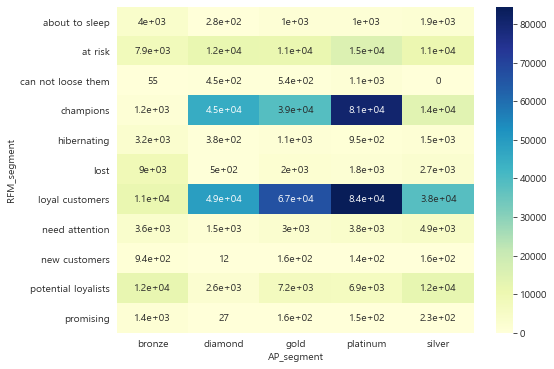

In [74]:
g = pd.pivot_table(df2, index='RFM_segment', columns='AP_segment', values='clnt_id', 
                                aggfunc= (lambda x : len(x) )  , fill_value=0)
plt.figure(figsize=(8,6))
sns.heatmap(g, annot=True, cmap="YlGnBu")

In [75]:
group1 = df2.query('RFM_segment in ["champions","loyal customers"] and AP_segment in ["diamond", "platinum"]')
group2 = df2.query('RFM_segment in ["promising","new customers"] and AP_segment in ["diamond", "platinum","gold", "sliver"]')
group3 = df2.query('RFM_segment in ["can not loose them","at risk"] and AP_segment in ["diamond", "platinum","gold", "sliver"]')
group4 = df2.query('RFM_segment in ["lost", "hibernating", "about to sleep"] and AP_segment in ["bronze"]')

####  GROUP1 서비스

In [76]:
h_price = group1.groupby('pd_c')['gd_price'].mean().quantile(0.999) 
group1.query('gd_price >= @h_price').clac_nm1.unique()

array(['Canned / Jarred Foods', "Women's Clothing",
       'Heating / Cooling Electronics', 'Health Care',
       'Refrigerators and Washing Machines', 'Coffee / Tea',
       'Fashion Accessories', 'Video / Audio System Electronics'],
      dtype=object)

In [77]:
h_price = group1.groupby('pd_c')['gd_price'].mean().quantile(0.999) 
group1.query('gd_price >= @h_price').clac_nm3.unique()

array(['Canned Mix Food Gift Sets', "Women's Coats",
       'Ceiling Type Air Conditioners', 'Massage Chairs',
       'Stand Type Refrigerators for Kimchi', 'Coffee Sets',
       "Women's Shoulder Bags", 'General Refrigerators', 'Camera Lenses',
       'Earrings', 'Pure Gold / Pure Silver / Ornaments'], dtype=object)

In [78]:
m1_price = group1.groupby('pd_c')['gd_price'].mean().quantile(0.55) 
m2_price = group1.groupby('pd_c')['gd_price'].mean().quantile(0.75) 
group1.query('@m1_price <= gd_price <= @m2_price').clac_nm3.value_counts().head(3).index

Index(['Frozen Dumplings', 'Domestic Porks - Bellys', 'Peaches'], dtype='object')

####  GROUP2 서비스

Text(0.5, 1.0, '오프라인 주구매시간')

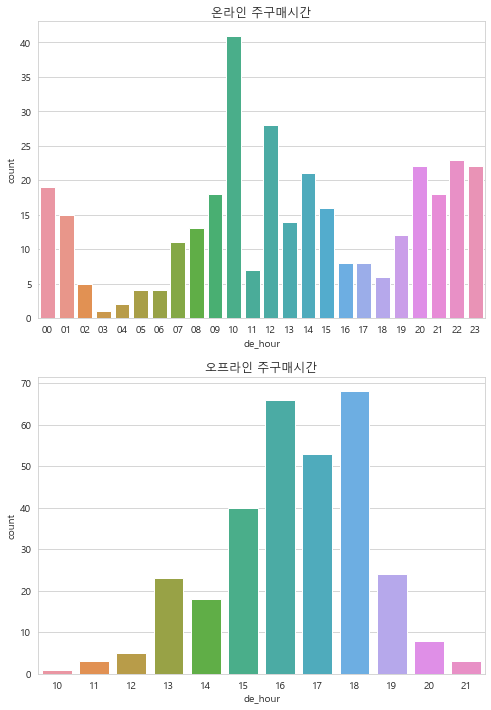

In [79]:
group2_on = group2.query('biz_unit in ["A01","A02","A03"]')
group2_off = group2.query('biz_unit in ["B01","B02","B03"]')

plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
sns.countplot( x = 'de_hour' , data = group2_on)
plt.title('온라인 주구매시간')
plt.subplot(2,1,2)
sns.countplot( x = 'de_hour' , data = group2_off)
plt.title('오프라인 주구매시간')